In [3]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


In [5]:
#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/lung-and-colon-cancer-histopathological-images.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [6]:
path = '/tmp/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_n', 'lung_scc', 'lung_aca']

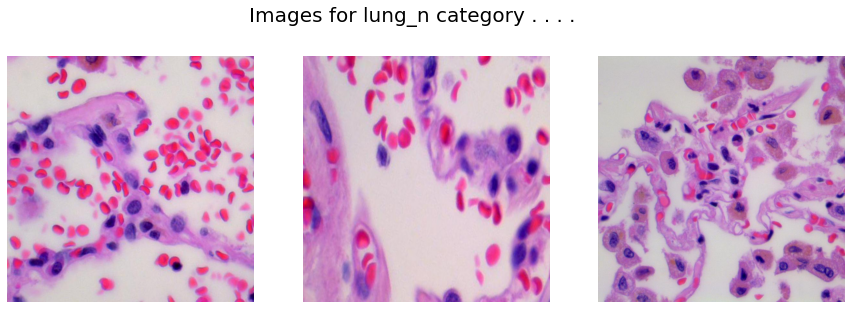

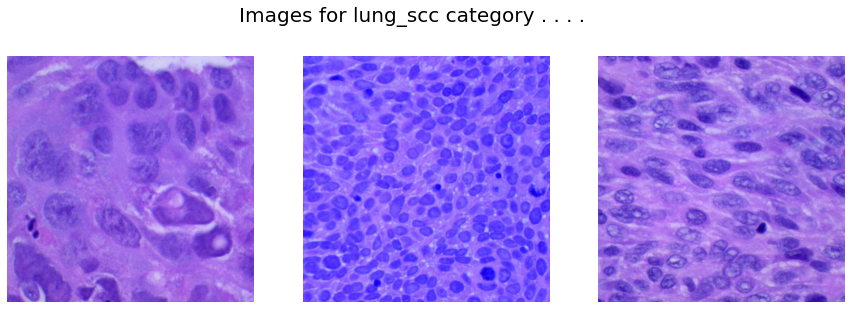

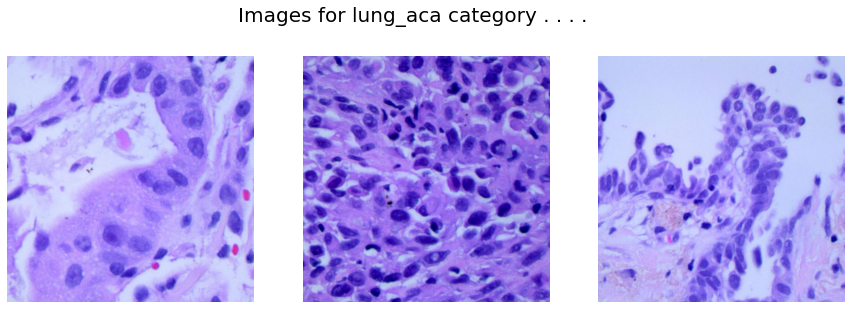

In [7]:
path = '/tmp/lung_colon_image_set/lung_image_sets'
for cat in classes:
  image_dir = f'{path}/{cat}'
  images = os.listdir(image_dir)
  fig, ax = plt.subplots(1, 3, figsize=(15, 5))
  fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

  for i in range(3):
      k = np.random.randint(0, len(images))
      img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
      ax[i].imshow(img)
      ax[i].axis('off')
  plt.show()


In [8]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64


In [9]:
X = []
Y = []
for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values



In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [11]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
                  layers.MaxPooling2D(2, 2),

                  layers.Conv2D(filters=64,
                                kernel_size=(3, 3),
                                activation='relu',
                                padding='same'),
                                 
                  layers.MaxPooling2D(2, 2),
                  layers.Conv2D(filters=128,
                                kernel_size=(3, 3),
                                activation='relu',
                                padding='same'),
                  layers.MaxPooling2D(2, 2),
                  layers.Flatten(),
                  layers.Flatten(),
                  layers.Dense(256, activation='relu'),
                  layers.BatchNormalization(),
                  layers.Dense(128, activation='relu'),
                  layers.Dropout(0.3),
                  layers.BatchNormalization(),
                  layers.Dense(3, activation='softmax')
    ])
                                
                            

In [12]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

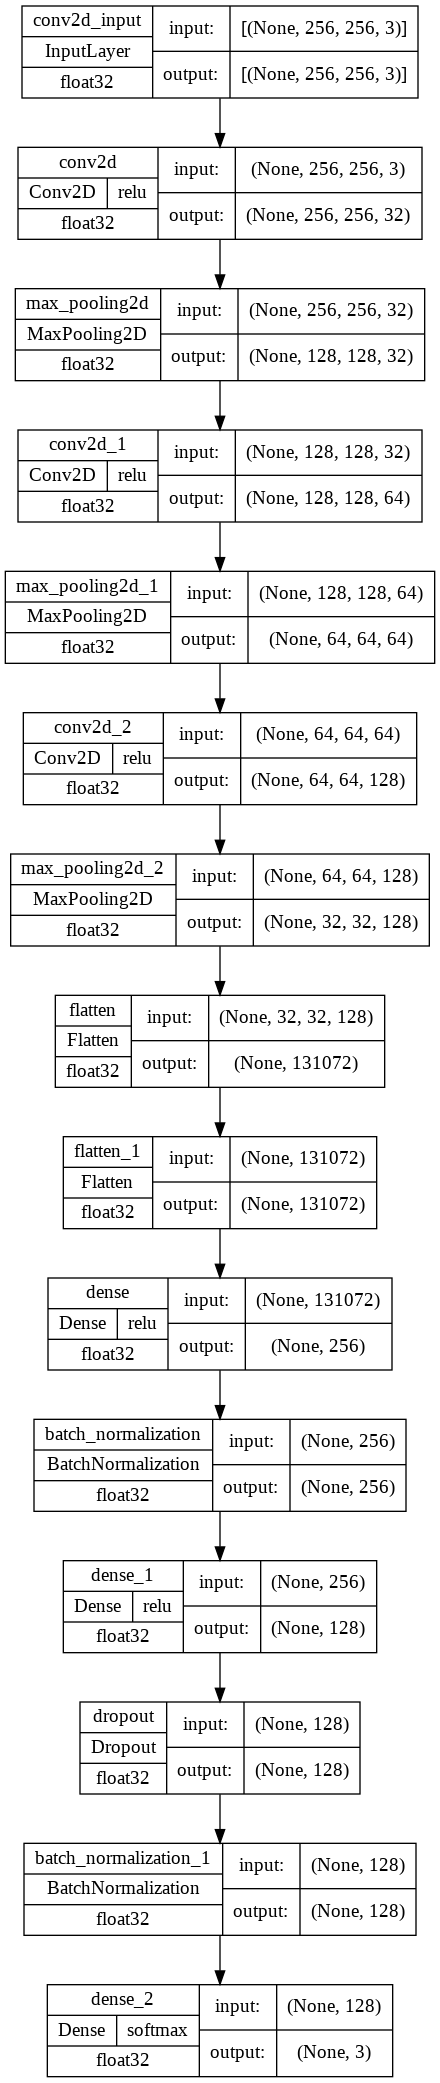

In [13]:
keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)


In [14]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)


In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


In [17]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])


Epoch 1/10
188/188 [==============================] - 2015s 11s/step - loss: 0.2080 - accuracy: 0.9162 - val_loss: 13.7865 - val_accuracy: 0.3267 - lr: 5.0000e-04
Epoch 2/10
188/188 [==============================] - 2004s 11s/step - loss: 0.1658 - accuracy: 0.9334 - val_loss: 1.7486 - val_accuracy: 0.5850 - lr: 5.0000e-04
Epoch 3/10
188/188 [==============================] - 2003s 11s/step - loss: 0.1196 - accuracy: 0.9552 - val_loss: 0.4117 - val_accuracy: 0.8847 - lr: 5.0000e-04
Epoch 4/10
188/188 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9659
 Validation accuracy has reached upto 					90% so, stopping further training.
188/188 [==============================] - 1997s 11s/step - loss: 0.0938 - accuracy: 0.9659 - val_loss: 0.3483 - val_accuracy: 0.9043 - lr: 5.0000e-04


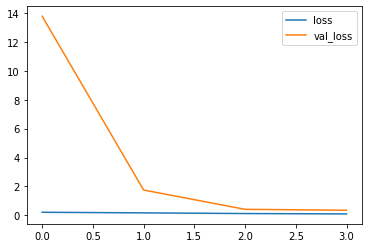

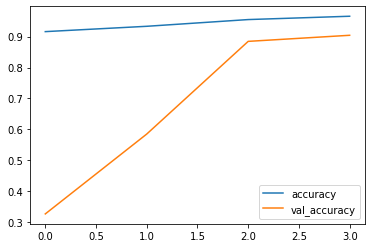

In [18]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


In [19]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


94/94 [==============================] - 137s 1s/step


In [20]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[909,   0,  78],
       [  1, 849, 127],
       [ 10,  71, 955]])

In [21]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))


              precision    recall  f1-score   support

      lung_n       0.99      0.92      0.95       987
    lung_scc       0.92      0.87      0.90       977
    lung_aca       0.82      0.92      0.87      1036

    accuracy                           0.90      3000
   macro avg       0.91      0.90      0.91      3000
weighted avg       0.91      0.90      0.91      3000

